In [1]:
import os
import re
from collections import defaultdict

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'

from adjustText import adjust_text

from Bio import SeqIO

from scipy import stats
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
datadir = '../data/dnaPipeTE-out'
dnapipete_counts_data = {sp: f'{datadir}/{sp}/Counts.txt' for sp in os.listdir(datadir)}

In [3]:
def parse_dnapipete_coverage(countfile):
    coverage_df = pd.read_csv(countfile, sep='\t', header=None, names=['teclass', 'readcount'])
    return coverage_df

def parse_dnapipete_family_counts():
    dnapipete_annots_data = {}
    for sp in os.listdir(datadir):
        tedict = {}
        for teclass in ['DNA', 'Helitron', 'LINE', 'LTR', 'SINE', 'others']:
            i = 0
            with open(f'{datadir}/{sp}/Annotation/{teclass}.headers') as infile:
                for line in infile:
                    i += 1
            tedict[teclass] = i
        dnapipete_annots_data[sp] = tedict
    df = pd.DataFrame.from_dict(dnapipete_annots_data, orient='index') \
                     .reset_index() \
                     .rename({'index': 'species'}, axis=1)
    df['interspersed'] = df.sum(axis=1)
    return df 

def parse_rmodeller_out():
    rmlibs = {
    'Danio_aesculapii': 'DanAes4_rmodeller_database-families.fa',
    'Danio_albolineatus': 'DanAlb1_rmodeller_database-families.fa',
    'Danio_choprai': 'DanCho1_rmodeller_database-families.fa',
    'Danionella_dracula': 'DanDra1_rmodeller_database-families.fa',
    'Danio_jaintianensis': 'DanJai1_rmodeller_database-families.fa',
    'Danio_kyathit': 'DanKya3_rmodeller_database-families.fa',
    'Danio_tinwini': 'DanTin1_rmodeller_database-families.fa',
    'Danionella_translucida': 'DanTra1_rmodeller_database-families.fa',
    'Danio_rerio': 'DreABz2_rmodeller_database-families.fa',
    }
    data = {}
    for species, filename in rmlibs.items():
        tedict = defaultdict(int)
        for record in SeqIO.parse(f'../data/repeatmodeller-out/{species}/{filename}', 'fasta'):
            if len(record.seq) < 100:
                continue
            tedata = record.name.split('#')[-1].split('/')
            teclass, tefam = tedata[0], tedata[-1]
            tedict[teclass] += 1
        data[species] = tedict
    df = pd.DataFrame.from_dict(data, orient='index') \
                     .reset_index() \
                     .rename({'index': 'species'}, axis=1)
    df['interspersed'] = df[['LTR', 'DNA', 'LINE', 'RC']].sum(axis=1) 
    return df.sort_values('species')

def count_finz_znf(species):
    count = 0
    with open('../data/seqs/cypriniformes_augustus_finz.fa') as infile:
        for line in infile:
            if line.startswith(f'>{species}'):
                count += 1
    return count

def count_finz_exons(species):
    count = 0
    with open(f'../data/blast-out/{species}_finz_locs.out') as infile:
        for line in infile:
            count += 1
    return count

def count_znf_hits(species):
    count = 0
    with open(f'../data/blast-out/{species}_znf_locs.out') as infile:
        for line in infile:
            count += 1
    return count

def age_proportions():
    divdict = defaultdict(list)
    for species in dnapipete_counts_data.keys():
        landscape_df = pd.read_csv(f'../data/dnaPipeTE-out/{species}/reads_landscape', 
                                   sep=r'\s+', 
                                   header=None, 
                                   names=['identity', 'tename', 'tefam', 'teclass'])
        landscape_df['divergence'] = 100 - landscape_df.identity
        step = 5
        total = landscape_df.tename.count()
        divdict['species'].append(species)
        for i in range(0, int(np.ceil(max(landscape_df.divergence)))+1+step, step):
            divdict[f'lt_{i}'].append(landscape_df.loc[landscape_df.divergence <= i, 'tename'].count()/total)
            divdict[f'gt_{i}'].append(landscape_df.loc[landscape_df.divergence > i, 'tename'].count()/total)
    return pd.DataFrame.from_dict(divdict)

## Building genomic TE coverage dataframes

In [4]:
coverage_dfs = []
for sp, val in dnapipete_counts_data.items():
    coverage_df = parse_dnapipete_coverage(val)
    coverage_df['species'] = sp
    coverage_df['finz_znf'] = count_finz_znf(sp)
    coverage_df['finz_exons'] = count_finz_exons(sp)
    coverage_df['znf_hits'] = count_znf_hits(sp)
    coverage_dfs.append(coverage_df)

coverage_df = pd.concat(coverage_dfs)
coverage_df = coverage_df.pivot_table(index=['species', 'finz_exons', 'finz_znf', 'znf_hits'], 
                                columns='teclass', 
                                values='readcount') \
    .sort_values('finz_znf') \
    .reset_index()
coverage_df['Unknown'] = coverage_df.na + coverage_df.others
coverage_df = coverage_df.drop(['Others', 'Tandem_repeats', 'na', 'others', 'rRNA', 'MITE', 'Simple_repeat'], axis=1)
coverage_df['interspersed'] = coverage_df.DNA + coverage_df.LTR + coverage_df.LINE + coverage_df.SINE + coverage_df.Helitron + coverage_df.Unknown
    
for teclass in ['DNA', 'Helitron', 'LINE', 'LTR', 'SINE', 'Low_Complexity', 'Satellite', 'Unknown', 'interspersed', 'Total']:
    coverage_df[teclass] = coverage_df[teclass]/coverage_df['Total']*100

with open('../data/species_genomes.txt') as infile:
    hiqual = [line.split()[0] for line in infile]
coverage_df = coverage_df.loc[coverage_df.species.isin(hiqual)]
coverage_df.to_csv('../data/finz_te_coverage.txt', sep='\t', index=False)

# The remaining dataframes are partially constructed off the back of the main coverage_df, or generated in R, as is the case for the pic_dfs.
counts_df = parse_dnapipete_family_counts()
counts_df = counts_df.merge(coverage_df[['species', 'finz_exons', 'finz_znf', 'znf_hits']], on='species', how='inner')

rmodeller_df = parse_rmodeller_out()
rmodeller_df = rmodeller_df.merge(coverage_df[['species', 'finz_znf', 'finz_exons', 'znf_hits']], on='species', how='inner')
rmodeller_df.to_csv('../data/finz_te_counts.txt', sep='\t', index=False)

pic_coverage_df = pd.read_csv('../data/finz_coverage_pics.txt', sep='\t')
pic_rmodeller_df = pd.read_csv('../data/finz_counts_pics.txt', sep='\t')

<ipython-input-3-b2bdcb99897c>:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['interspersed'] = df.sum(axis=1)


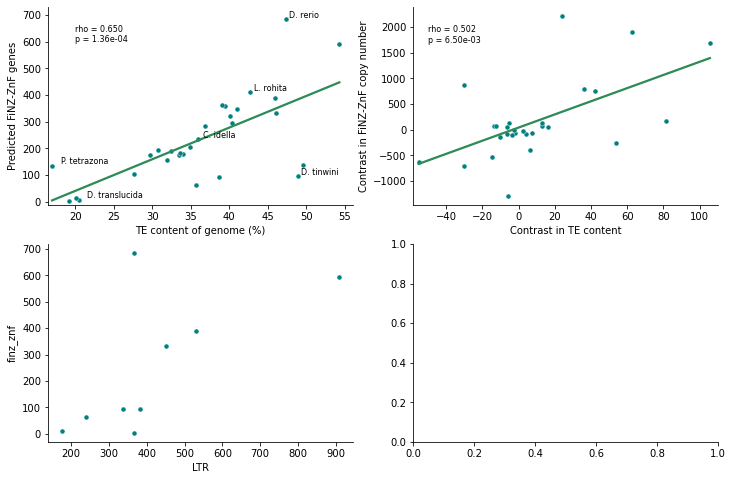

In [5]:
column = 'interspersed'
column2 = 'finz_znf'
dataframe = coverage_df.loc[(~coverage_df.species.str.startswith('Chanos')) & (~coverage_df.species.str.startswith('Triplophysa'))]
dataframe2 = rmodeller_df

# Define 2x2 grid
fig, ax = plt.subplots(figsize=(12, 8), ncols=2, nrows=2)

###############################################################################
## Plot panel A: Regression plot of genomic TE coverage and FiNZ-ZnF count
###############################################################################

sns.regplot(data=dataframe, 
            x=column, 
            y=column2,
            scatter=False,
            ci=None,
            color='seagreen',
            ax=ax[0][0])

sns.scatterplot(data=dataframe, 
                x=column, 
                y=column2,
                color='teal',
                s=25,
                ax=ax[0][0])

ax[0][0].set_xlim(16.5, 56)
ax[0][0].set_ylim(-10, 730)
ax[0][0].set_xlabel('TE content of genome (%)')
ax[0][0].set_ylabel('Predicted FiNZ-ZnF genes')

labels = []
for row in dataframe.iterrows():
    label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
    if label not in ['D. rerio', 'D. tinwini', 'P. tetrazona', 'L. rohita', 'C. idella', 'D. translucida', 'P. huangchuchieni']:
        continue
    labels.append(ax[0][0].text(row[1][column], row[1][column2], 
                             label, 
                             fontsize=8, 
                             va='center', 
                             ha='center'))
adjust_text(labels)

pval = stats.spearmanr(dataframe[column], 
                       dataframe[column2])
ax[0][0].text(x=20, 
        y=600, 
        s=f'rho = {pval[0]:.3f}\np = {pval[1]:.2e}',
        fontsize=8)

###############################################################################
## Plot panel B: Phylogenetically independents contrasts of genomic TE coverage
## and FiNZ-ZnF count.
###############################################################################

sns.regplot(data=pic_coverage_df, 
            x=f'pic.{column}', 
            y=f'pic.{column2}',
            scatter=False,
            ci=None,
            color='seagreen',
            ax=ax[0][1])

sns.scatterplot(data=pic_coverage_df, 
                x=f'pic.{column}', 
                y=f'pic.{column2}',
                color='teal',
                s=25,
                ax=ax[0][1])


ax[0][1].set_xlabel('Contrast in TE content')
ax[0][1].set_ylabel('Contrast in FiNZ-ZnF copy number')

picpval = stats.spearmanr(pic_coverage_df[f'pic.{column}'], 
                       pic_coverage_df['pic.finz_znf'])

ax[0][1].text(x=-50, 
           y=1700, 
           s=f'rho = {picpval[0]:.3f}\np = {picpval[1]:.2e}',
           fontsize=8)
ax[0][1].set_xlim(-58, 110)

###############################################################################
## Plot panel C: Correlation between predicted numbers of LTR families and
## FiNZ-ZnF genes within Danioninae species.
###############################################################################

sns.scatterplot(data=dataframe2, 
                x='LTR', 
                y=column2,
                color='teal',
                s=25,
                ax=ax[1][0])
# labels = []
# for row in dataframe2.iterrows():
#     label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
#     labels.append(ax[1][0].text(row[1][column], row[1][column2], 
#                              label, 
#                              fontsize=8, 
#                              va='bottom', 
#                              ha='left'))

pval = stats.spearmanr(dataframe2[column], 
                       dataframe2[column2])
ax[1][0].text(x=1700, 
        y=600, 
        s=f'rho = {pval[0]:.3f}\np = {pval[1]:.2e}',
        fontsize=8)

sns.despine()
plt.show()
fig.savefig('../figs/finz_znf_corr.pdf', bbox_inches='tight', dpi=300)

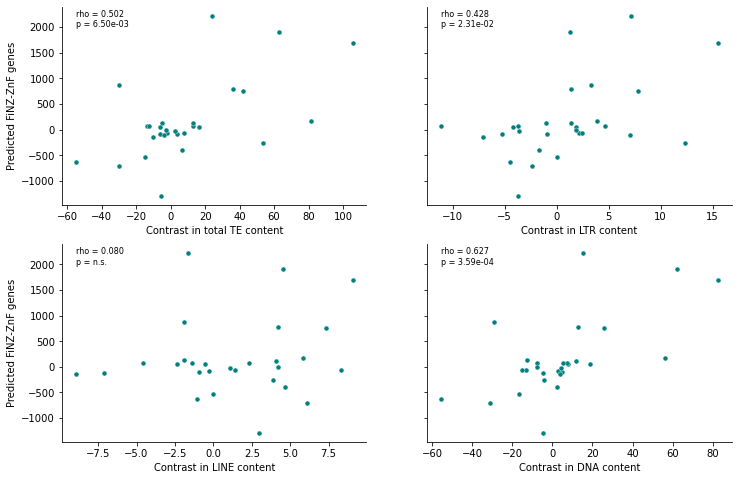

In [35]:
column2 = 'pic.finz_znf'
dataframe = pic_coverage_df
# Define 2x2 grid
fig, ax = plt.subplots(figsize=(12, 8), ncols=2, nrows=2, sharey=True)

i, j = 0, 0
for teclass in ['pic.interspersed', 'pic.LTR', 'pic.LINE', 'pic.DNA']:
    # sns.regplot(data=dataframe, 
    #             x=teclass, 
    #             y=column2,
    #             scatter=False,
    #             ci=None,
    #             color='seagreen',
    #             ax=ax[i][j])

    sns.scatterplot(data=dataframe, 
                    x=teclass, 
                    y=column2,
                    color='teal',
                    s=25,
                    ax=ax[i][j])
    
    if teclass == 'pic.interspersed':
        lab = 'total TE'
    else:
        lab = teclass.strip('pic.')
    ax[i][j].set_xlabel(f'Contrast in {lab} content')
    ax[i][j].set_ylabel('Predicted FiNZ-ZnF genes')

    pval = stats.spearmanr(dataframe[teclass], 
                           dataframe[column2])
    if pval[1] < 0.05:
        p = f'{pval[1]:.2e}'
    else:
        p = 'n.s.'
    ax[i][j].text(x=min(dataframe[teclass]), 
                  y=2000, 
                  s=f'rho = {pval[0]:.3f}\np = {p}',
                  fontsize=8)
    j += 1
    if j > 1:
        i += 1
        j = 0
sns.despine()
plt.show()
fig.savefig('../figs/teclass_finz_correlation.pdf', bbox_inches='tight')

A possible explanation for some of the noise in the correlation is genome assembly quality. Since the finz-znfs are normally present on specific, highly repetitive chromosomes, it is possible that low numbers of predicted genes could be due to collapsing or fragmentation of these regions. To test this, we will look at the correlation between N50 and finz count.

In [23]:
n50_df = pd.read_csv('/Users/jonwells/Projects/feschottelab/metazoan-znfs/data/znf_ret_counts.txt', sep='\t') \
           .dropna()[['species', 'scaffold_n50']] \
           .merge(coverage_df, on='species', how='inner')
print(n50_df.sort_values('scaffold_n50'))

                            species  scaffold_n50  finz_exons  finz_znf  \
21         Oxygymnocypris_stewartii        257093         280       137   
24    Sinocyclocheilus_anophthalmus        310307         498       179   
15      Hypophthalmichthys_molitrix        314181          99        16   
13           Danionella_translucida        340819           5         9   
16                      Labeo_catla        719175         455       285   
28     Sinocyclocheilus_rhinocerous        945738         415       176   
26         Sinocyclocheilus_grahami       1156368         550       174   
25     Sinocyclocheilus_anshuiensis       1284143         400       195   
27  Sinocyclocheilus_maitianheensis       1361887         390       189   
17                     Labeo_rohita       1959535         715       410   
30           Triplophysa_siluroides       2872994           1         0   
4                   Culter_alburnus       3669388         504       358   
0               Anabarili

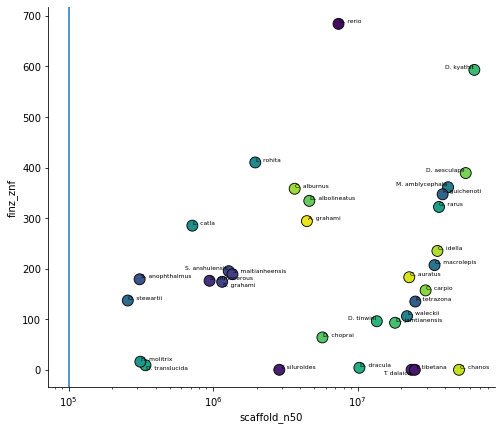

SpearmanrResult(correlation=0.19083465445202485, pvalue=0.2874163188764552)
SpearmanrResult(correlation=0.12165775401069519, pvalue=0.5000346509203469)


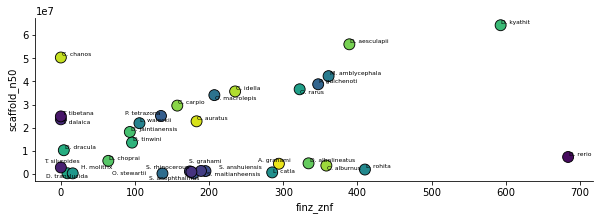

SpearmanrResult(correlation=0.19083465445202485, pvalue=0.2874163188764552)


In [24]:
min_N50 = 1e05
column = 'finz_znf'

fig, ax = plt.subplots(figsize=(8, 7)) 
sns.scatterplot(data=n50_df, 
                x='scaffold_n50', 
                y=column,
                hue='species',
                palette='viridis_r',
                edgecolor='k',
                s=120,
                ax=ax)
ax.axvline(x=min_N50)
ax.set_xscale('log')
ax.get_legend().remove()

labels = []
for row in n50_df.iterrows():
    label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
    labels.append(ax.text(row[1]['scaffold_n50'], row[1][column], label, size=6, va='center', ha='center'))
adjust_text(labels)

sns.despine()
plt.show()
print(stats.spearmanr(n50_df.loc[n50_df['scaffold_n50'] >= min_N50].scaffold_n50, n50_df.loc[n50_df['scaffold_n50'] >= min_N50][column]))
print(stats.spearmanr(n50_df.loc[n50_df['scaffold_n50'] >= min_N50].scaffold_n50, n50_df.loc[n50_df['scaffold_n50'] >= min_N50].interspersed))

fig, ax = plt.subplots(figsize=(10, 3)) 
sns.scatterplot(data=n50_df.loc[n50_df['scaffold_n50'] >= min_N50], 
                y='scaffold_n50', 
                x=column,
                hue='species',
                palette='viridis_r',
                edgecolor='k',
                s=120,
                ax=ax)
ax.get_legend().remove()

labels = []
for row in n50_df.loc[n50_df['scaffold_n50'] >= min_N50].iterrows():
    label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
    labels.append(ax.text(row[1][column], row[1]['scaffold_n50'], label, size=6, va='center', ha='center'))
adjust_text(labels)

sns.despine()
plt.show()

print(stats.spearmanr(n50_df.loc[n50_df['scaffold_n50'] >= min_N50].scaffold_n50, n50_df.loc[n50_df['scaffold_n50'] >= min_N50][column]))

In [25]:
print(n50_df.loc[n50_df['N50'] >= min_N50].reset_index().species)
n50_df.loc[n50_df['N50'] >= min_N50].reset_index()[['species']].to_csv('../data/n50_gt5e05.txt', header=False, index=False)

KeyError: 'N50'

In [26]:
def parse_rmodeller_out():
    rmlibs = {}
    for species in os.listdir(f'../data/repeatmodeller-out/'):
        for f in os.listdir(f'../data/repeatmodeller-out/{species}'):
            if f.endswith('_clustered_families.fa'):
                rmlibs[species] = f
    data = {}
    for species, filename in rmlibs.items():
        ltr, teline, dna, unknown = 0, 0, 0, 0
        with open(f'../data/repeatmodeller-out/{species}/{filename}') as infile:
            # infile.readline()
            # infile.readline()
            for line in infile:
                if line.startswith('>'):
                    teclass = line.split(' ')[0].split('#')[1].split('/')[0]
                    fsize = re.search('Family Size = (\d+)', line)
                    if fsize != None:
                        fsize = int(fsize.group(1))
                    else:
                        fsize = 11
                    if fsize < 10:
                        continue
                    if teclass == 'LTR':
                        if 'Type=LTR' in line:
                            ltr += 1
                    elif teclass == 'LINE':
                        teline += 1
                    elif teclass == 'DNA':
                        dna += 1
                    elif teclass == 'Unknown':
                        unknown += 1
        data[species] = [ltr, teline, dna, unknown]
    df = pd.DataFrame.from_dict(data, orient='index') \
                     .reset_index() \
                     .rename({'index': 'species', 0:'ltr', 1:'line', 2:'dna', 3:'Unknown'}, axis=1)
    return df.sort_values('species')

In [ ]:
rmodeller_df = parse_rmodeller_out()
rmodeller_df = rmodeller_df.merge(coverage_df[['species', 'finz_znf', 'finz_exons']], on='species', how='inner')
print(rmodeller_df)
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=rmodeller_df.loc[rmodeller_df.species], x='ltr', y='finz_znf')
# for row in rmodeller_df.iterrows():
#     label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
#     labels.append(ax.text(row[1]['interspersed'], row[1]['finz_znf'], label, size=6, va='center', ha='center'))
# adjust_text(labels)

print(stats.spearmanr(rmodeller_df.ltr, rmodeller_df.finz_znf))